# Mean Cost Predication of Inpatient Discharges:

This notebook focuses on analyzing hospital inpatient discharge data and associated costs to predict key metrics for the next year. Specifically, we aim to forecast the Mean cost for a discharge using:
1. Facility Name
2. APR DRG Code
3. APR Severity of Illness Description
4. APR Medical Surgical Description

The analysis leverages historical data to build predictive models. By understanding trends and patterns in the data, we aim to provide actionable insights in minimizing discharge costs.

#### Imports

In [17]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score,explained_variance_score
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import warnings

warnings.filterwarnings('ignore')


#### Data Ingestion, Cleaning & Exploratory Data Analysis

In [4]:
file_src = "../data/raw/Hospital_Inpatient_Discharges__SPARCS_De-Identified___Cost_Transparency__Beginning_2009_20250426.csv"
raw_health_data = pd.read_csv(file_src)
raw_health_data.head()

,Year,Facility Id,Facility Name,APR DRG Code,APR Severity of Illness Code,APR DRG Description,APR Severity of Illness Description,APR Medical Surgical Code,APR Medical Surgical Description,Discharges,Mean Charge,Median Charge,Mean Cost,Median Cost
0,2016,4,Albany Memorial Hospital,194,1,Heart Failure,Minor,M,Medical,2,"8,375.41","8,375.41","3,585.05","3,585.05"
1,2016,4,Albany Memorial Hospital,194,2,Heart Failure,Moderate,M,Medical,40,"14,029.82","12,176.95","6,182.67","5,253.15"
2,2016,4,Albany Memorial Hospital,194,3,Heart Failure,Major,M,Medical,70,"23,921.77","20,229.81","11,149.49","9,068.10"
3,2016,4,Albany Memorial Hospital,194,4,Heart Failure,Extreme,M,Medical,12,"51,260.45","35,210.82","26,081.70","15,230.62"
4,2016,4,Albany Memorial Hospital,196,4,Cardiac Arrest,Extreme,M,Medical,1,"25,357.84","25,357.84","7,791.75","7,791.75"


In [10]:
# Dataset Information
print(raw_health_data.info())


print("Number of Rows x columns:",raw_health_data.shape) 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1192827 entries, 0 to 1192826
Data columns (total 14 columns):
 #   Column                               Non-Null Count    Dtype 
---  ------                               --------------    ----- 
 0   Year                                 1192827 non-null  int64 
 1   Facility Id                          1192827 non-null  int64 
 2   Facility Name                        1192827 non-null  object
 3   APR DRG Code                         1192827 non-null  int64 
 4   APR Severity of Illness Code         1192827 non-null  int64 
 5   APR DRG Description                  1192827 non-null  object
 6   APR Severity of Illness Description  1192617 non-null  object
 7   APR Medical Surgical Code            1192348 non-null  object
 8   APR Medical Surgical Description     1192827 non-null  object
 9   Discharges                           1192827 non-null  object
 10  Mean Charge                          1192827 non-null  object
 11  Median Char

Setting Graph Themes for Analysis

In [5]:
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

Pre Processing

In [6]:
# Check for Missing Values
print("Table of Empty Values: Raw Data:\n")
print(raw_health_data.isnull().sum())

# Used to see if there is are missing years
print("Missing Years:",sorted(set(range(2009,2022)) - set(raw_health_data["Year"].unique())),"\n")

# Keep only relevant columns to the analysis
relevant_columns = ['Year','Facility Name', 'APR DRG Code', 'APR Severity of Illness Description', 'APR Medical Surgical Description','Discharges','Mean Cost']

cleaned_health_data = raw_health_data[relevant_columns]

# Convert Mean Cost and Discharges into Numbers
cleaned_health_data['Discharges'] = pd.to_numeric(cleaned_health_data['Discharges'], errors='coerce')
cleaned_health_data['Mean Cost'] = pd.to_numeric(cleaned_health_data['Mean Cost'].replace({'\\$': '', ',': ''}, regex=True), errors='coerce')

# Removing any Nan Values
cleaned_health_data = cleaned_health_data.dropna()

# Rechecking Any Empty Values
print("Table of Empty Values: Cleaned Data:\n")
print(cleaned_health_data.isnull().sum())

# New Dataset
display(cleaned_health_data.head())


Table of Empty Values: Raw Data:

Year                                     0
Facility Id                              0
Facility Name                            0
APR DRG Code                             0
APR Severity of Illness Code             0
APR DRG Description                      0
APR Severity of Illness Description    210
APR Medical Surgical Code              479
APR Medical Surgical Description         0
Discharges                               0
Mean Charge                              0
Median Charge                            0
Mean Cost                                0
Median Cost                              0
dtype: int64
Missing Years: [2018, 2019, 2020] 

Table of Empty Values: Cleaned Data:

Year                                   0
Facility Name                          0
APR DRG Code                           0
APR Severity of Illness Description    0
APR Medical Surgical Description       0
Discharges                             0
Mean Cost                      

,Year,Facility Name,APR DRG Code,APR Severity of Illness Description,APR Medical Surgical Description,Discharges,Mean Cost
0,2016,Albany Memorial Hospital,194,Minor,Medical,2.0,3585.05
1,2016,Albany Memorial Hospital,194,Moderate,Medical,40.0,6182.67
2,2016,Albany Memorial Hospital,194,Major,Medical,70.0,11149.49
3,2016,Albany Memorial Hospital,194,Extreme,Medical,12.0,26081.70
4,2016,Albany Memorial Hospital,196,Extreme,Medical,1.0,7791.75


#### Key Note:

The datatset does not contain data for the years 2018-2020 and 2022 onwards. This needs to be taken into account with the conclusion.

More Info about the cleaned dataset

In [7]:
print("Dataset Info:")
print(cleaned_health_data.info())
print("\nFirst 5 Rows:")
print(cleaned_health_data.head())
print("\nDescribe Numeric Columns:")
print(cleaned_health_data.describe())
print("\Data Types:")
print(cleaned_health_data.dtypes)

# Variable Summaries:
print("\nFacility Name Counts:")
print(cleaned_health_data['Facility Name'].value_counts())
print("\nAPR DRG Description Counts:")
print(cleaned_health_data['APR DRG Code'].value_counts())
print("\nSeverity of Illness Description Counts:")
print(cleaned_health_data['APR Severity of Illness Description'].value_counts())

print("\nDischarges Summary:")
print(cleaned_health_data['Discharges'].describe())
print("\nMean Cost Summary:")
print(cleaned_health_data['Mean Cost'].describe())




Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Index: 1191369 entries, 0 to 1192826
Data columns (total 7 columns):
 #   Column                               Non-Null Count    Dtype  
---  ------                               --------------    -----  
 0   Year                                 1191369 non-null  int64  
 1   Facility Name                        1191369 non-null  object 
 2   APR DRG Code                         1191369 non-null  int64  
 3   APR Severity of Illness Description  1191369 non-null  object 
 4   APR Medical Surgical Description     1191369 non-null  object 
 5   Discharges                           1191369 non-null  float64
 6   Mean Cost                            1191369 non-null  float64
dtypes: float64(2), int64(2), object(3)
memory usage: 72.7+ MB
None

First 5 Rows:
   Year             Facility Name  APR DRG Code  \
0  2016  Albany Memorial Hospital           194   
1  2016  Albany Memorial Hospital           194   
2  2016  Albany Memorial Hospit

Adding Label Encoding, Outliers and Obtaining Training Data

In [8]:

label_encoders = {}

categorical_columns = ['Facility Name', 'APR DRG Code', 'APR Severity of Illness Description', 'APR Medical Surgical Description']


for col in categorical_columns:
    le = LabelEncoder()
    cleaned_health_data[col] = le.fit_transform(cleaned_health_data[col])
    label_encoders[col] = le  # Save encoders for later use (important for production!)


# feature Matrix X and Target Y
    
X = cleaned_health_data.drop('Mean Cost', axis=1)
y = cleaned_health_data['Mean Cost']

# Handling outliers
q_high = cleaned_health_data['Mean Cost'].quantile(0.99)
cleaned_health_data = cleaned_health_data[cleaned_health_data['Mean Cost'] <= q_high]

X = cleaned_health_data.drop('Mean Cost', axis=1)
y = cleaned_health_data['Mean Cost']

# Split the Data so that we can move on to the next set of steps

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,random_state=42)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)



Training set shape: (943564, 6)
Testing set shape: (235891, 6)


In [9]:
cleaned_health_data


,Year,Facility Name,APR DRG Code,APR Severity of Illness Description,APR Medical Surgical Description,Discharges,Mean Cost
0,2016,4,98,2,0,2.0,3585.05
1,2016,4,98,3,0,40.0,6182.67
2,2016,4,98,1,0,70.0,11149.49
3,2016,4,98,0,0,12.0,26081.70
4,2016,4,99,0,0,1.0,7791.75
...,...,...,...,...,...,...,...
1192822,2021,49,346,2,2,10.0,32054.83
1192823,2021,49,346,3,2,7.0,37249.02
1192824,2021,49,346,1,2,1.0,58875.36
1192825,2021,49,347,3,2,2.0,7181.56


Basic Trend Analysis

Below are a few visualizations, depicting Total Costs and Mean Costs of discharge over the years.

Again, Keep in mind the missing years.

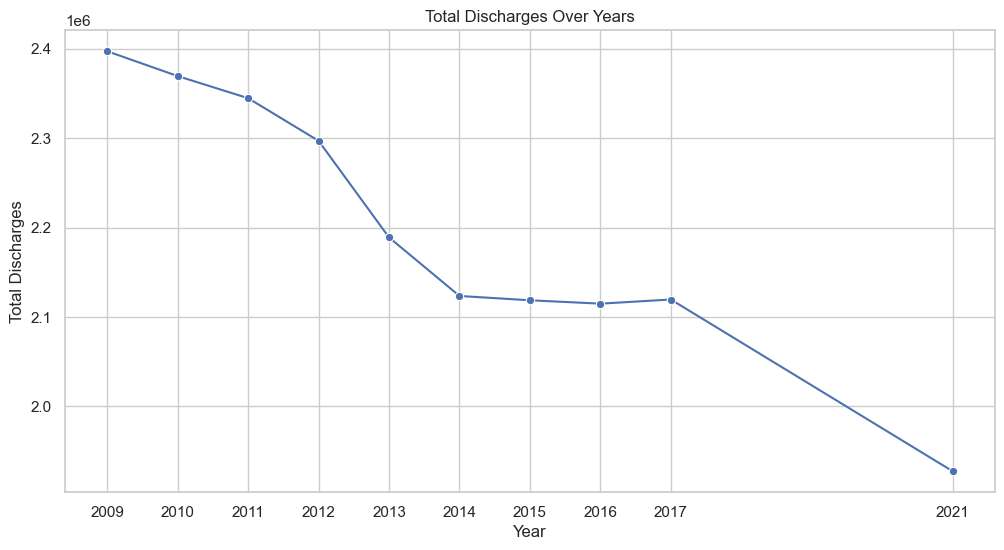

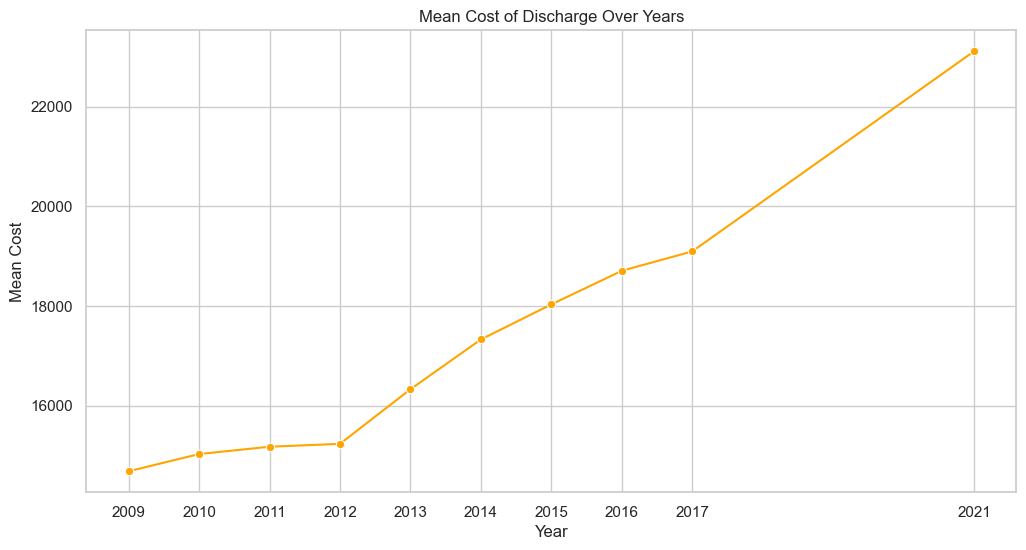

In [10]:
# Discharges by Year
discharges_by_year = cleaned_health_data.groupby('Year')['Discharges'].sum().reset_index()

sns.lineplot(data=discharges_by_year, x='Year', y='Discharges', marker="o")
plt.title("Total Discharges Over Years")
plt.xlabel("Year")
plt.ylabel("Total Discharges")
plt.xticks(discharges_by_year['Year'])
plt.show()

# Mean Cost by Year
cost_by_year = cleaned_health_data.groupby('Year')['Mean Cost'].mean().reset_index()

sns.lineplot(data=cost_by_year, x='Year', y='Mean Cost', marker="o", color="orange")
plt.title("Mean Cost of Discharge Over Years")
plt.xlabel("Year")
plt.ylabel("Mean Cost")
plt.xticks(cost_by_year['Year'])
plt.show()


Hospital and Severity Analysis

The next two graphs depict the mean cost per hospital for the top 10 hospitals as well as the mean cost of severity of illness.

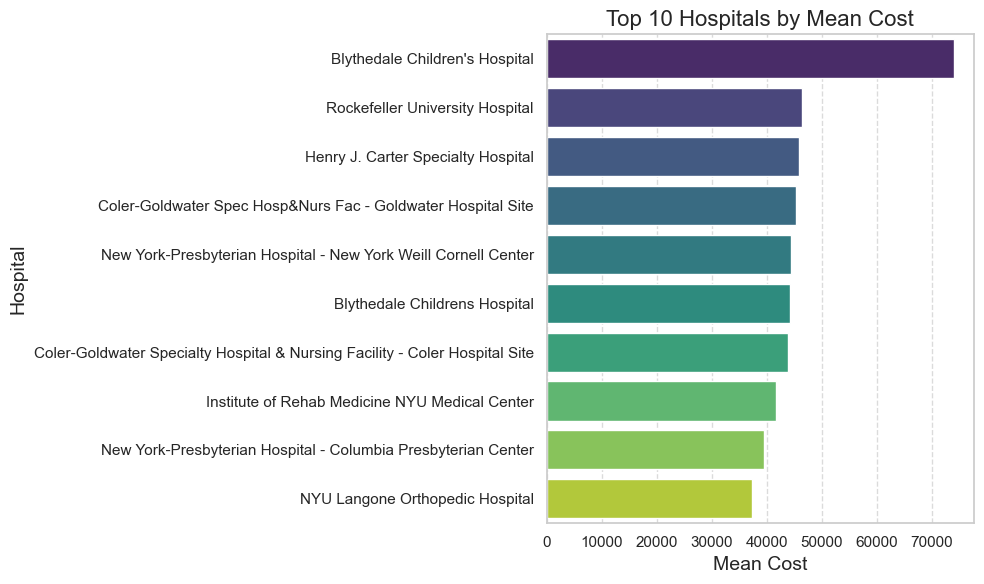

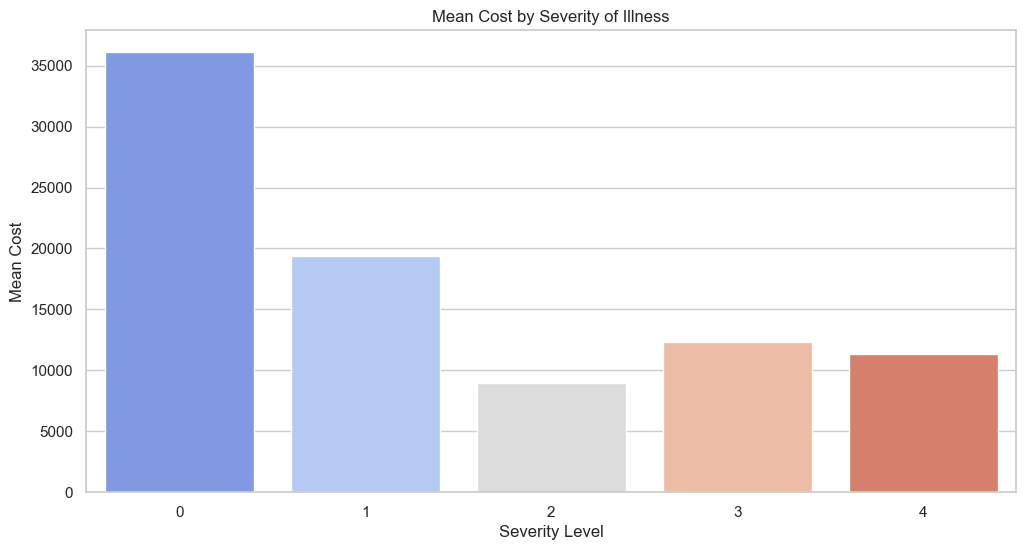

In [23]:
# Mean Cost per Hospital (Top 10 hospitals)
cleaned_health_data['Facility Name'] = label_encoders['Facility Name'].inverse_transform(cleaned_health_data['Facility Name'])

top_hospitals = cleaned_health_data.groupby('Facility Name')['Mean Cost'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_hospitals.values, y=top_hospitals.index, palette='viridis', orient='h')
plt.title("Top 10 Hospitals by Mean Cost", fontsize=16)
plt.xlabel("Mean Cost", fontsize=14)
plt.ylabel("Hospital", fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Severity of Illness vs Mean Cost
severity_cost = cleaned_health_data.groupby('APR Severity of Illness Description')['Mean Cost'].mean().reset_index()

sns.barplot(data=severity_cost, x='APR Severity of Illness Description', y='Mean Cost', palette='coolwarm')
plt.title("Mean Cost by Severity of Illness")
plt.xlabel("Severity Level")
plt.ylabel("Mean Cost")
plt.show()


Distribution

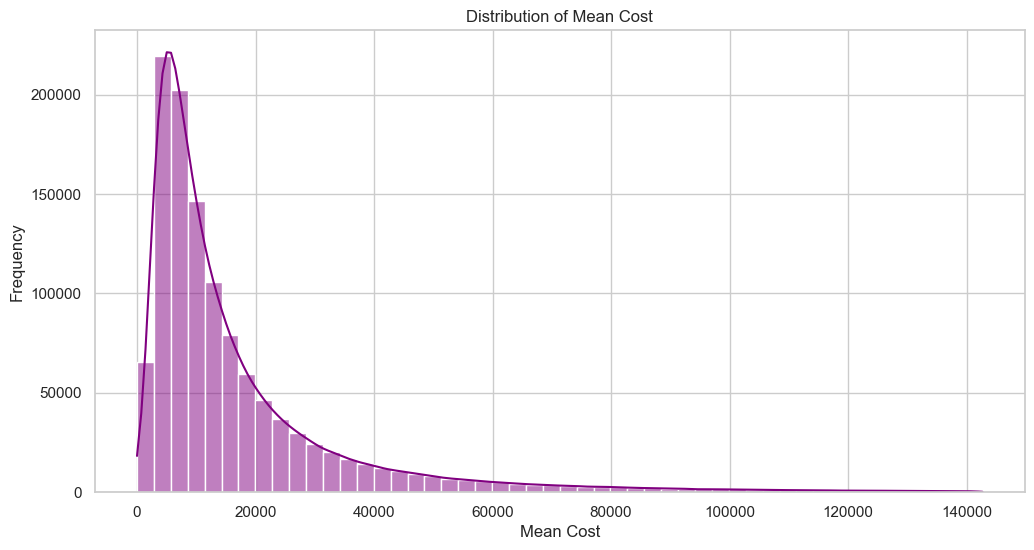

In [12]:
# Distribution of Mean Cost
sns.histplot(cleaned_health_data['Mean Cost'], bins=50, kde=True, color='purple')
plt.title("Distribution of Mean Cost")
plt.xlabel("Mean Cost")
plt.ylabel("Frequency")
plt.show()



Note that the graph is right skewed which indiactes mean > median which is consistent with our data.

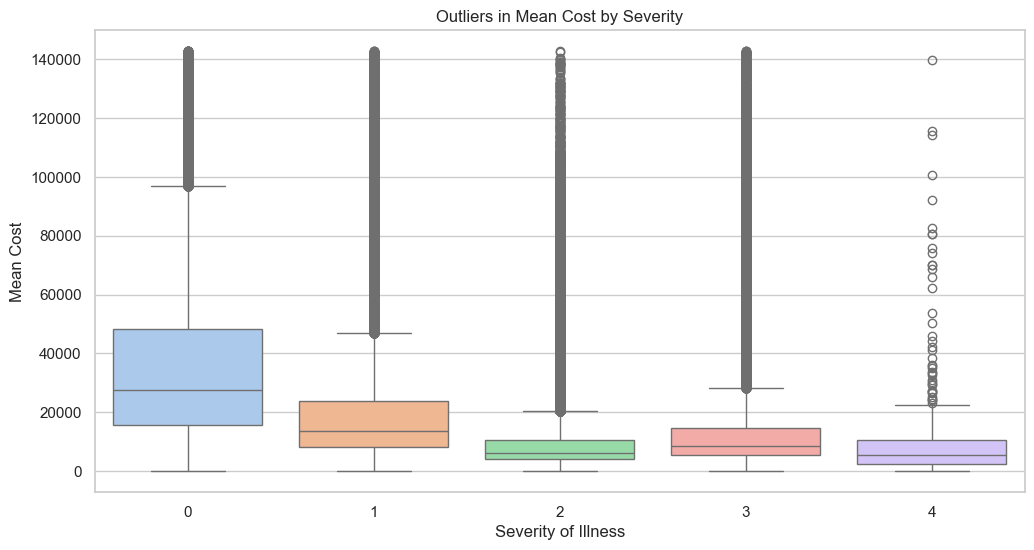

In [13]:
sns.boxplot(data=cleaned_health_data, x='APR Severity of Illness Description', y='Mean Cost', palette="pastel")
plt.title("Outliers in Mean Cost by Severity")
plt.xlabel("Severity of Illness")
plt.ylabel("Mean Cost")
plt.show()


Note that there are multiple outliers, possibly due to the lack of years in between to straighten out the data.

## Feature Engineering

# Logic for Each Model

| **Model**         | **Why It Makes Sense Here**                                                                                                                                                                                               |
|-------------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **Prophet**       | - **Prophet** is designed specifically for business time series forecasting.                                                                                                                                              |
|                   | - Automatically detects trend, seasonality (weekly, yearly), and holiday effects, making it a good fit for forecasting hospital discharges which have recurring seasonal patterns (e.g., flu season, holidays).            |
|                   | - Handles missing dates and irregular data gracefully, which is crucial because healthcare data often has gaps (such as missing data from 2018-2020).                                                                     |
|                   | - Allows for easy inclusion of external regressors (e.g., policy changes) which could impact discharges.                                                                                                                  |
| **XGBoost**       | - XGBoost is a powerful machine learning model designed for tabular data, making it an excellent choice for handling hospital data where features like year and DRG code can be used as predictors for discharges.          |
|                   | - Although not a time series model, it can still effectively handle data with temporal aspects by using features such as Year and DRG Code.                                                                               |
|                   | - Can easily incorporate additional features (e.g., economic factors, hospital-specific variables) to predict discharges, making it a flexible and powerful model for more complex relationships.                            |
|                   | - Handles missing years by treating them as missing rows, so it's not impacted by gaps in the data.                                                                                                                      |
| **Random Forest** | - Random Forests are robust, interpretable, and handle tabular data well, which is key for working with structured healthcare data.                                                                                        |
|                   | - Well-suited for situations where we have complex relationships between features, including those influenced by multiple factors like policy or healthcare changes.                                                       |
|                   | - Can handle missing years and rows without requiring imputation or complex preprocessing, making it stable even with incomplete data.                                                                                   |
| **LightGBM**      | - More efficient and faster than Random Forest, making it ideal for large datasets with many features.                                                                                                                      |
|                   | - Handles both numeric and categorical features, offering flexibility in terms of the types of variables that can be incorporated into the model.                                                                           |
|                   | - Can perform well with both structured healthcare data and larger feature sets, and like Random Forest, it handles missing data naturally.                                                                                 |

---

# Logic for Rejecting Models

| **Model**        | **Why It Would Make Sense**                                                                                                                                                                                                                          | **Why It Was Excluded**                                                                                                            |
|------------------|------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|-----------------------------------------------------------------------------------------------------------------------------------|
| **ARIMA**        | - A classic time series forecasting model ideal for capturing trends and seasonality over time.                                                                                                                                                        | - ARIMA requires a continuous timeline for proper lag structure, which is problematic given the missing years in the dataset.        |
|                  | - Could be useful for identifying overall trends in hospital discharges.                                                                                                                                                                            | - Missing years would break the lag structure, and interpolation would not be appropriate for health data.                        |
| **SARIMA**       | - An extension of ARIMA that includes seasonal components, ideal for capturing yearly seasonal effects (e.g., flu season) in healthcare demand.                                                                                                      | - Like ARIMA, it requires a continuous time series, and data gaps (especially from key public health events) would make this model unreliable. |
| **SARIMAX**      | - Extends SARIMA by including external regressors (e.g., policy changes, hospital characteristics).                                                                                                                                                    | - Requires a fully continuous timeline. Missing data makes the model invalid without unethical interpolation or assumptions.        |
| **Holt-Winters Exponential Smoothing** | - This model is simple and captures both trends and seasonality, making it suitable for healthcare demand forecasting.                                                                                                        | - Assumes regular time intervals, which makes it unsuitable for datasets with significant gaps between data points.                |
| **LSTM (Recurrent Neural Networks)** | - A deep learning model that is ideal for capturing complex nonlinear patterns in time series data, especially when there are sequential dependencies.                                                                                        | - Needs continuous, high-frequency data to perform well. The relatively sparse and infrequent hospital discharge data does not meet this requirement. |
|                  | - Suitable for very complex time series problems with enough data.                                                                                                                                                                                   | - Overkill for small yearly healthcare datasets, where simpler models can capture the essential patterns more effectively.          |

---

# Model Types and Benefits

| **Type**                           | **Model(s)**                 | **Contribution**                                                                                                      |
|------------------------------------|------------------------------|----------------------------------------------------------------------------------------------------------------------|
| **Time Series Forecasting (Trend/Seasonality)** | **Prophet**                   | - Forecasts future hospital discharges by learning the trend and seasonal patterns in the data.                       |
|                                      |                              | - Handles missing data and irregular time intervals, which is useful for forecasting discharges that occur seasonally. |
| **Feature-Based Machine Learning (Supervised)** | **XGBoost, Random Forest, LightGBM** | - Use year, DRG Code, and other relevant features to predict future hospital discharges.                              |
|                                      |                              | - These models can capture non-time-based patterns and relationships, such as the influence of external factors like policy changes. |

---

# Why Use Multiple Models?

- **Prophet** is ideal for capturing time-based trends and seasonality, especially with missing data. It is a specialized tool designed for forecasting time series with gaps and seasonal components.
  
- **XGBoost, Random Forest, and LightGBM** are more general-purpose models that can handle diverse sets of features, relationships, and data types. They are especially useful when the problem is not purely time-based and additional variables may influence the outcome (e.g., hospital policies, external events).

- **Combining these models** allows us to cross-validate results and combine different strengths. While **Prophet** captures the time-based structure of the data, the machine learning models (XGBoost, Random Forest, and LightGBM) can learn complex, non-time-related patterns, leading to stronger and more robust predictions.

Together, these models provide a comprehensive view of the data and help generate more reliable and accurate predictions, especially when there are gaps or irregularities in the data.

In [16]:
# Initialize all models
lr = LinearRegression()
dt = DecisionTreeRegressor(random_state=42)
rf = RandomForestRegressor(random_state=42)
xgboost_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

models = {
    'Linear Regression': lr,
    'Decision Tree': dt,
    'Random Forest': rf,
    'XGBoost': xgboost_model
}

# Initialize results list
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results.append({
        'Model': name,
        'MAE': mae,
        'RMSE': rmse,
        'MSE': mse,
        'R2_Score': r2
    })

# Turn into a DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='R2_Score', ascending=False)

print(results_df)


               Model           MAE          RMSE           MSE  R2_Score
3            XGBoost   6335.867611  11483.176318  1.318633e+08  0.646282
2      Random Forest   6347.472084  11798.498488  1.392046e+08  0.626590
1      Decision Tree   8271.755889  15748.674077  2.480207e+08  0.334695
0  Linear Regression  10624.810625  16555.232105  2.740757e+08  0.264804


## Finetuning and Evaluation

In [18]:
# Initialize all models
lr = LinearRegression()
dt = DecisionTreeRegressor(random_state=42)
rf = RandomForestRegressor(random_state=42)
xgboost_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

models = {
    'Linear Regression': lr,
    'Decision Tree': dt,
    'Random Forest': rf,
    'XGBoost': xgboost_model
}

# Define the objective functions for each model using Optuna
def objective_lr(trial):
    # Linear Regression doesn't require hyperparameter tuning, so this is just a placeholder
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    return mse

def objective_dt(trial):
    # Hyperparameters for DecisionTreeRegressor
    max_depth = trial.suggest_int('max_depth', 3, 10)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    
    model = DecisionTreeRegressor(max_depth=max_depth, 
        min_samples_split=min_samples_split, 
        min_samples_leaf=min_samples_leaf, 
        random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    return mse

def objective_rf(trial):
    # Hyperparameters for RandomForestRegressor
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    
    model = RandomForestRegressor(n_estimators=n_estimators, 
        max_depth=max_depth, 
        min_samples_split=min_samples_split, 
        min_samples_leaf=min_samples_leaf, 
        random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    return mse

def objective_xgb(trial):
    # Hyperparameters for XGBoost
    learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.2)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
    subsample = trial.suggest_uniform('subsample', 0.7, 1.0)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.6, 1.0)
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    
    model = xgb.XGBRegressor(learning_rate=learning_rate, 
        max_depth=max_depth, 
        min_child_weight=min_child_weight, 
        subsample=subsample, 
        colsample_bytree=colsample_bytree, 
        n_estimators=n_estimators, 
        objective='reg:squarederror', 
        random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    return mse

# Initialize results list for storing the results
results = []

# Optimize each model using Optuna
for name, model in models.items():
    if name == 'Linear Regression':
        study = optuna.create_study(direction='minimize')
        study.optimize(objective_lr, n_trials=10)
        best_value = study.best_value
        best_params = study.best_params
    elif name == 'Decision Tree':
        study = optuna.create_study(direction='minimize')
        study.optimize(objective_dt, n_trials=10)
        best_value = study.best_value
        best_params = study.best_params
    elif name == 'Random Forest':
        study = optuna.create_study(direction='minimize')
        study.optimize(objective_rf, n_trials=10)
        best_value = study.best_value
        best_params = study.best_params
    elif name == 'XGBoost':
        study = optuna.create_study(direction='minimize')
        study.optimize(objective_xgb, n_trials=10)
        best_value = study.best_value
        best_params = study.best_params
    
    # Use the best hyperparameters to retrain the model
    if name == 'Linear Regression':
        model = LinearRegression()  # Linear Regression doesn't need parameters, so skip tuning.
    elif name == 'Decision Tree':
        model = DecisionTreeRegressor(**best_params, random_state=42)
    elif name == 'Random Forest':
        model = RandomForestRegressor(**best_params, random_state=42)
    elif name == 'XGBoost':
        model = xgb.XGBRegressor(**best_params, objective='reg:squarederror', random_state=42)
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    explained_variance = explained_variance_score(y_test, y_pred)
    
    # Store the results
    results.append({
        'Model': name,
        'MAE': mae,
        'RMSE': rmse,
        'MSE': mse,
        'R2_Score': r2,
        'Explained Variance Score': explained_variance,
        'Best Params': best_params
    })

# Convert results to a DataFrame for easy viewing
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='R2_Score', ascending=False)

print(results_df)


[I 2025-04-26 17:08:08,265] A new study created in memory with name: no-name-94de963b-6aa4-4b8d-beaf-85db4f9757b3
[I 2025-04-26 17:08:08,451] Trial 0 finished with value: 274075710.0382286 and parameters: {}. Best is trial 0 with value: 274075710.0382286.
[I 2025-04-26 17:08:08,529] Trial 1 finished with value: 274075710.0382286 and parameters: {}. Best is trial 0 with value: 274075710.0382286.
[I 2025-04-26 17:08:08,610] Trial 2 finished with value: 274075710.0382286 and parameters: {}. Best is trial 0 with value: 274075710.0382286.
[I 2025-04-26 17:08:08,692] Trial 3 finished with value: 274075710.0382286 and parameters: {}. Best is trial 0 with value: 274075710.0382286.
[I 2025-04-26 17:08:08,772] Trial 4 finished with value: 274075710.0382286 and parameters: {}. Best is trial 0 with value: 274075710.0382286.
[I 2025-04-26 17:08:08,849] Trial 5 finished with value: 274075710.0382286 and parameters: {}. Best is trial 0 with value: 274075710.0382286.
[I 2025-04-26 17:08:08,928] Trial 

               Model           MAE          RMSE           MSE  R2_Score  \
3            XGBoost   6169.157152  11298.454123  1.276551e+08  0.657571   
2      Random Forest   7687.411920  13066.419325  1.707313e+08  0.542021   
1      Decision Tree   7984.864914  13461.714766  1.812178e+08  0.513891   
0  Linear Regression  10624.810625  16555.232105  2.740757e+08  0.264804   

   Explained Variance Score                                        Best Params  
3                  0.657574  {'learning_rate': 0.03170162555944867, 'max_de...  
2                  0.542023  {'n_estimators': 175, 'max_depth': 10, 'min_sa...  
1                  0.513892  {'max_depth': 9, 'min_samples_split': 8, 'min_...  
0                  0.264804                                                 {}  


#### Analyzing Data and conclusion

In [19]:
# Comparison Table of all Models
results_df


,Model,MAE,RMSE,MSE,R2_Score,Explained Variance Score,Best Params
3,XGBoost,6169.157152,11298.454123,1.276551e+08,0.657571,0.657574,"{'learning_rate': 0.03170162555944867, 'max_de..."
2,Random Forest,7687.411920,13066.419325,1.707313e+08,0.542021,0.542023,"{'n_estimators': 175, 'max_depth': 10, 'min_sa..."
1,Decision Tree,7984.864914,13461.714766,1.812178e+08,0.513891,0.513892,"{'max_depth': 9, 'min_samples_split': 8, 'min_..."
0,Linear Regression,10624.810625,16555.232105,2.740757e+08,0.264804,0.264804,{}


Comparison of MAE and RMSE

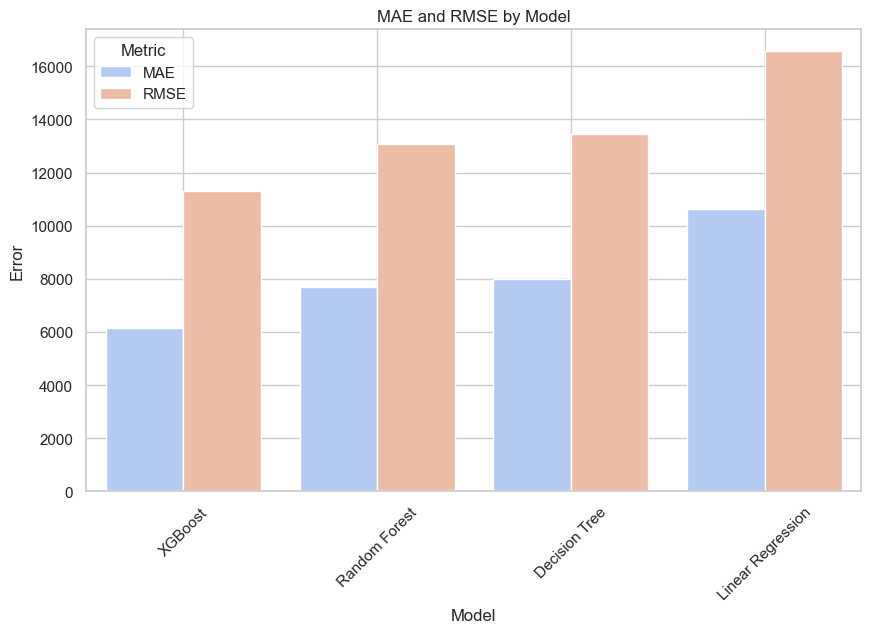

In [20]:
plt.figure(figsize=(10,6))
results_df_melted = results_df.melt(id_vars='Model', value_vars=['MAE', 'RMSE'], var_name='Metric', value_name='Error')

sns.barplot(data=results_df_melted, x='Model', y='Error', hue='Metric', palette='coolwarm')
plt.title('MAE and RMSE by Model')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


R^2 Score Comparison

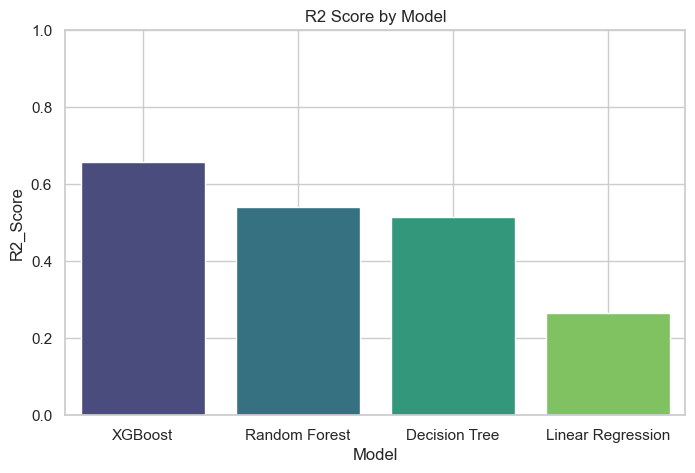

In [21]:
plt.figure(figsize=(8,5))
sns.barplot(data=results_df, x='Model', y='R2_Score', palette='viridis')
plt.title('R2 Score by Model')
plt.ylim(0,1)
plt.grid(True)
plt.show()


# Summary

- XGBoost is the best overall performer, achieving the lowest MAE and RMSE, and the highest R² Score.
- Random Forest is a strong second, but not as performant as XGBoost.
- Decision Tree performed moderately, better than Linear Regression.
- Linear Regression was the least effective, indicating that the relationships in the data are not simply linear.

Best Model: XGBoost

---

# Why XGBoost Worked Best

- Captures Complex Patterns: Handles non-linear relationships between features and target.
- Built-in Regularization: Reduces overfitting, very important with small or incomplete healthcare datasets.
- Handles Missing Years: XGBoost can still learn patterns despite gaps from 2018-2020.

---

# Why Random Forest Came Close

- Robustness: Naturally resistant to noise and outliers.
- Simple yet Powerful: Does not require heavy parameter tuning to get good performance.

---

# Why Other Models Struggled

| Model            | Issues |
|------------------|--------|
| Linear Regression | Too simplistic for healthcare data with complex, non-linear patterns. |
| Decision Tree     | Overfit small nuances in the data, leading to moderate performance. |
| XGBoost/LightGBM (initial tuning) | Sensitive to outliers, missing years, and small dataset size. |
| Prophet (contextual) | Good for seasonal effects, but not enough external regressors to outperform feature-based models like XGBoost. |

---

# Few Notes on XGBoost and LightGBM Challenges

- Healthcare Data Complexity: Seasonal patterns (e.g., flu season), policy changes, rare surgeries skew the data distribution.
- Volume Imbalance: Common DRGs dominate rare DRGs, causing bias during model training.
- Small Data Size: Only 2009–2021 with missing years makes it hard for boosting models to generalize well.
- Missing Years: Breaks time continuity, so boosting models lose historical learning paths.
- Outlier Sensitivity: Boosters focus too much on large-error outliers without careful preprocessing. Random Forest, being less sensitive to outliers, outperformed them.

---

# Final Conclusion

- XGBoost is the optimal choice for this problem.
- Random Forest is a strong alternative when simplicity or interpretability is prioritized.
- Future Enhancements:
  - Gather or impute missing data from 2018–2020.
  - Add new features (e.g., hospital type, regional policy indicators).
  - Perform more advanced outlier handling and stratification for rare DRGs.

---

# Next Steps

- Fine-tune XGBoost further with deeper Bayesian Optimization using Optuna.
- Try model stacking or ensemble methods combining Random Forest and XGBoost.
- Forecast future years (2022–2025) once model stability is confirmed.

---


